In [4]:
from matplotlib import pyplot as plt
import os
import scipy
import cv2
import numpy as np
from cv2 import imread
from fnc.segment import segment, findTopEyelid, findBottomEyelid
from fnc.normalize import normalize
from fnc.encode import encode
from fnc.boundary import searchInnerBound, searchOuterBound
from fnc.line import findline, linecoords
from fnc.matching import calHammingDist
import multiprocessing as mp

/Users/overbydl/SoCoDeN/Iris-Recognition/python
read image--
[168, 171, 42]
[168, 171, 42]
imwithnoise.shape (280, 320)
(20, 240)
[[54.36785131 54.36785131 54.36785131 ... 54.36785131 54.36785131
  54.36785131]
 [54.36785131 54.36785131 54.36785131 ... 54.36785131 54.36785131
  54.36785131]
 [54.36785131 54.36785131 54.36785131 ... 54.36785131 54.36785131
  54.36785131]
 ...
 [63.52941176 65.09803922 56.07843137 ... 54.50980392 60.78431373
  63.52941176]
 [63.52941176 57.25490196 51.76470588 ... 54.50980392 60.78431373
  63.52941176]
 [63.52941176 57.25490196 51.76470588 ... 63.52941176 58.43137255
  63.52941176]]
(20, 240)


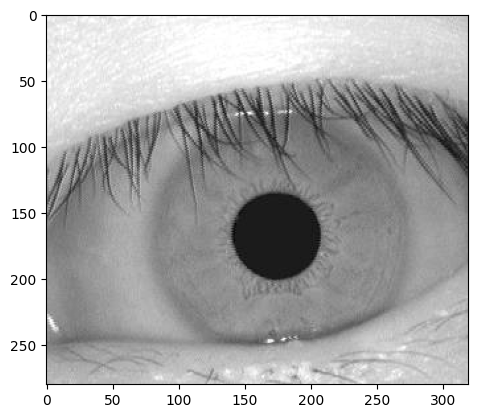

In [5]:
#lessons learned -- can't just change X/4 in the boundary.py to something else to fix the error of 
#index 280 is out of bounds for axis 0 with size 280 size - it messes up the iris radius calculation
#seems like the masking fo eyelid is not working properly - comment that out in segment.py file
#line 85 in segment.py imwithnoise = imwithnoise #+ mask_top + mask_bot
#line 118 in boundary.py maxrad = np.round(inner_r/0.1).astype(int) #this was set to .3 but the paper is .1

#TO DO:
#1- figure out the issue with index 280 is out of bound
#2- masking of eyelids doesn't seemt to work properly
#3- might need a higher threshold range than .33 that was used in the paper

print(os.getcwd())
im = cv2.imread("../CASIA1/61/061_1_1.jpg", 0)
print("read image--")
# Segmentation parameters
eyelashes_thres = 80
# Normalisation parameters
radial_res = 20
angular_res = 240
##line 85 in segment.py had to be changed imwithnoise = imwithnoise #+ mask_top + mask_bot
ciriris, cirpupil, imwithnoise = segment(im, eyelashes_thres, False)
print(ciriris)
print(ciriris)
print("imwithnoise.shape", imwithnoise.shape)
#cv2.imwrite(filename="im_aftersegmentation.jpg",imwithnoise)
polar_array, noise_array = normalize(imwithnoise, ciriris[1], ciriris[0], ciriris[2],
										 cirpupil[1], cirpupil[0], cirpupil[2],
										 radial_res, angular_res)
print(polar_array.shape)
print(polar_array*100)
cv2.imwrite(filename="im_polararray.jpg",img=polar_array*100)
print(noise_array.shape)
#cv2.imshow('im_polararray',polar_array) 

plt.imshow(im, cmap='gray')



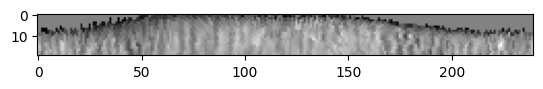

In [6]:
plt.imshow(polar_array,cmap='gray')

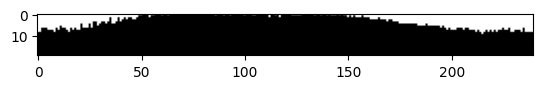

In [7]:
plt.imshow(noise_array,cmap='gray')

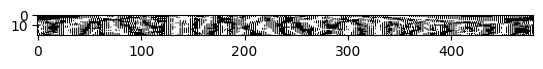

In [8]:
# Feature encoding parameters
minWaveLength = 18
mult = 1
sigmaOnf = 0.5
template, mask = encode(polar_array, noise_array, minWaveLength, mult, sigmaOnf)
plt.imshow(template,cmap='gray')


In [9]:
dist=calHammingDist(template, mask, template, mask)
print("dist",dist)

dist 0.0


In [10]:
im2 = cv2.imread("../CASIA1/61/061_1_3.jpg", 0)
ciriris2, cirpupil2, imwithnoise2 = segment(im2, eyelashes_thres, False)
polar_array2, noise_array2 = normalize(imwithnoise2, ciriris2[1], ciriris2[0], ciriris2[2],
										 cirpupil2[1], cirpupil2[0], cirpupil2[2],
										 radial_res, angular_res)
template2, mask2 = encode(polar_array2, noise_array2, minWaveLength, mult, sigmaOnf)




In [11]:
dist=calHammingDist(template, mask, template2, mask2)
print("dist",dist)

dist 0.46495507060333763


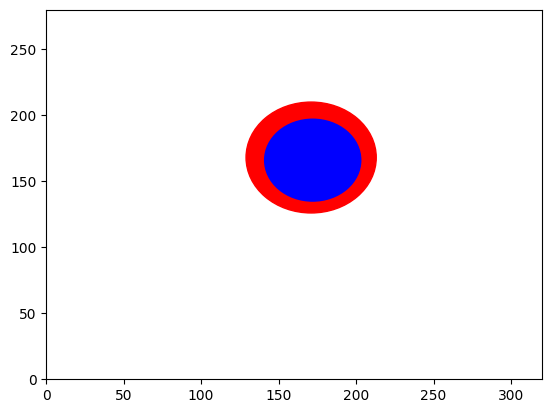

In [12]:
#switched row/col, cirirs[0] and cirirs[1]
circle1 = plt.Circle((ciriris[1], ciriris[0]), ciriris[2], color='r')
circle2 = plt.Circle((cirpupil[1], cirpupil[0]), cirpupil[2], color='b')
figure, axes=plt.subplots()
axes.set_xlim((0, 320))
axes.set_ylim((0, 280))#axes.set_ylim((280, 0))
axes.add_artist(circle1)
axes.add_artist(circle2)
plt.show()

153.0
178.0
35


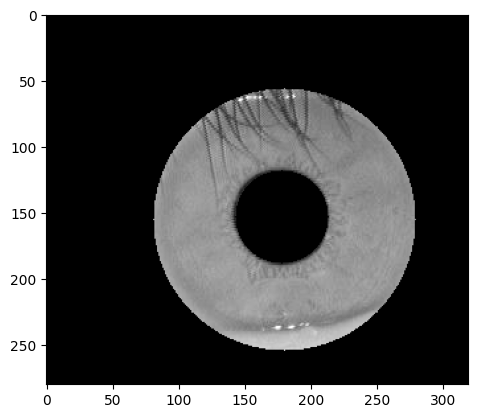

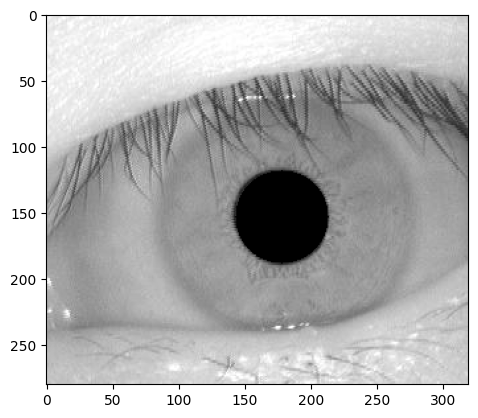

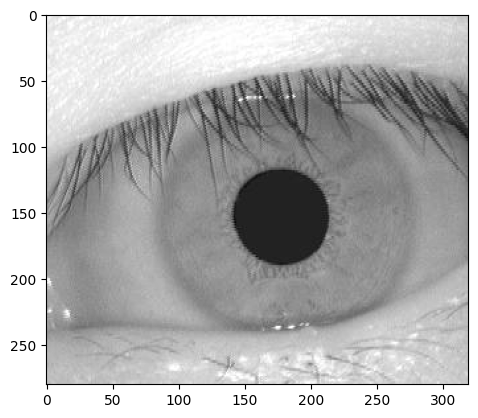

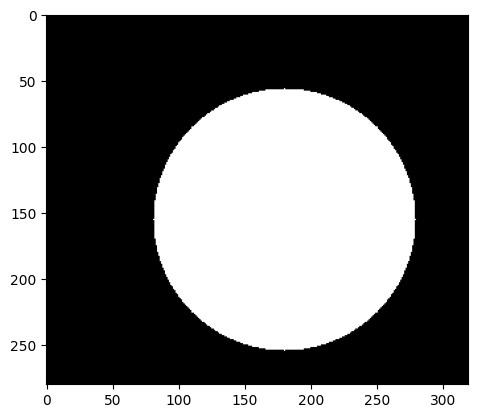

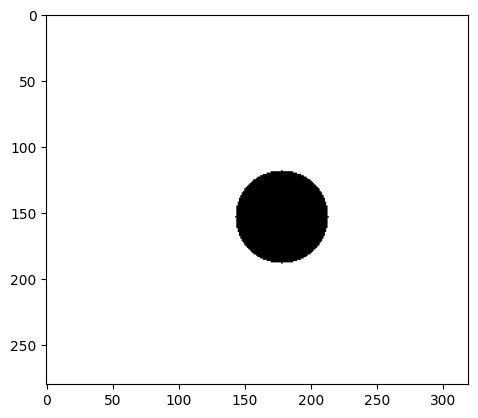

In [42]:
from matplotlib.patches import Circle
rowp, colp, rp = searchInnerBound(im2)
row, col, r = searchOuterBound(im2, rowp, colp, rp)

print(rowp)
print(colp)
print(rp)
fig, ax = plt.subplots(1)
#ax.imshow(im2, cmap="gray")
#ax.axis('off')
#switched order of row  and col - row is y, col is x
circ2 = Circle((col,row), r, edgecolor = 'blue',alpha=.3)
circ = Circle((colp,rowp), rp, edgecolor = 'red',alpha=.3)
mask = np.zeros_like(im2)
mask = 255-mask
#mask2 = np.zeros(im2.shape)
imm = cv2.circle(mask, (int(colp),int(rowp)), rp, (0,0,0),-1)
mask2 = np.zeros_like(im2)
immm = cv2.circle(mask2, (int(col),int(row)), r, (255,255,255), -1)
# apply mask to image
#result = cv2.bitwise_and(im2, mask2)
#immm = cv2.circle(mask2, (int(col),int(row)), r, (0,0,0),-1)
#newmask = imm + immm
newim = cv2.bitwise_and(im2, imm)
fig4, ax4 = plt.subplots(1)
ax4.imshow(newim, cmap="gray")
newim2 = cv2.bitwise_and(newim, immm)
# save the result
#ax.add_patch(circ2)
#ax.add_patch(circ)
ax.imshow(newim2, cmap="gray")

fig1, ax1 = plt.subplots(1)
ax1.imshow(im2, cmap="gray")

fig2, ax2 = plt.subplots(1)
ax2.imshow(mask2, cmap="gray")

fig3, ax3 = plt.subplots(1)
ax3.imshow(mask, cmap="gray")

#plt.imshow(im,cmap='gray')
#plt.Circle((rowp,colp),rp)

155.0
180.0
99
153
56
35
62
132


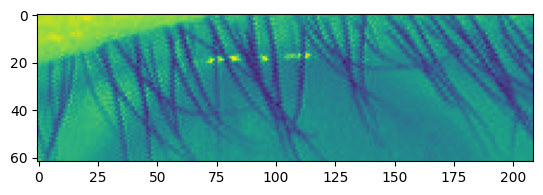

In [ ]:
imsz = im.shape

print(row)
print(col)
print(r)

irl = np.round(row - r).astype(int) #iris lower
iru = np.round(row + r).astype(int) #iris upper
icl = np.round(col - r).astype(int) #iris left
icu = np.round(col + r).astype(int) #iris right
if irl < 0:
    irl = 0
if icl < 0:
    icl = 0
if iru >= imsz[0]:
    iru = imsz[0] - 1
if icu >= imsz[1]:
    icu = imsz[1] - 1
imageiris = im[irl: iru + 1, icl-10: icu + 1]

plt.imshow(imageiris,cmap="gray")
rowp=rowp.astype(int) #center pupil
irl=irl.astype(int) #iris lower
rp=rp.astype(int) #radius pupil

print(rowp)
print(irl)
print(rp)
print(rowp - irl - rp)
topeyelid = imageiris[0: rowp - irl - rp, :]
plt.imshow(topeyelid)

print(rowp - irl + rp )
bottomeyelid = imageiris[rowp - irl + rp - 1 : imageiris.shape[0], :]
#plt.imshow(bottomeyelid)
#mask_top = findTopEyelid(imsz, imageiris, irl, icl, rowp, rp)
#print(mask_top)
#mask_bot = findBottomEyelid(imsz, imageiris, rowp, rp, irl, icl)

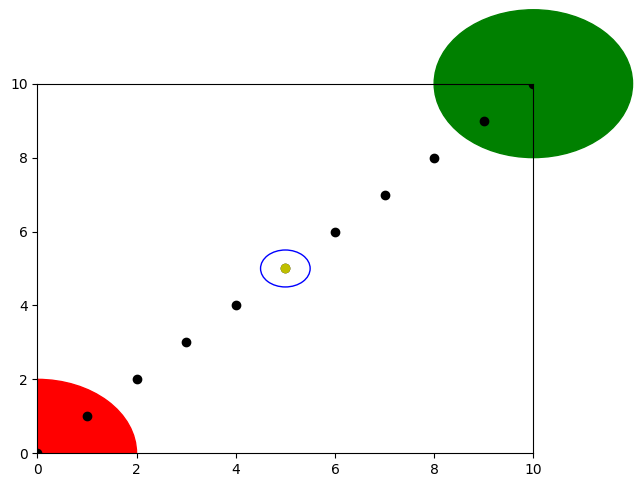

In [ ]:
circle1 = plt.Circle((0, 0), 2, color='r')
# now make a circle with no fill, which is good for hi-lighting key results
circle2 = plt.Circle((5, 5), 0.5, color='b', fill=False)
circle3 = plt.Circle((10, 10), 2, color='g', clip_on=False)
    
ax = plt.gca()
ax.cla() # clear things for fresh plot

# change default range so that new circles will work
ax.set_xlim((0, 10))
ax.set_ylim((0, 10))
# some data
ax.plot(range(11), 'o', color='black')
# key data point that we are encircling
ax.plot((5), (5), 'o', color='y')
    
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)

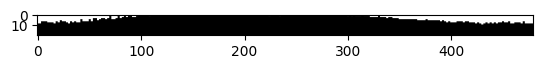

In [ ]:
minWaveLength = 18
mult = 1
sigmaOnf = 0.5
template, mask = encode(polar_array, noise_array, minWaveLength, mult, sigmaOnf)
plt.imshow(mask,cmap='gray')

In [ ]:
im = cv2.imread("/Users/sadeghin/research/Iris/example/Iris-Recognition//CASIA1/1/001_1_3.jpg", 0)
print(im.shape)
img = cv2.medianBlur(im,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,10,
                            param1=60,param2=35,minRadius=37,maxRadius=100)

print(circles[0,:])




[ WARN:0@3518.210] global loadsave.cpp:244 findDecoder imread_('/Users/sadeghin/research/Iris/example/Iris-Recognition//CASIA1/1/001_1_3.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
ciriris, cirpupil, imwithnoise = segment(im, 80, False)
print("***",ciriris)
print("***",cirpupil)

cv2.circle(cimg,(ciriris[0]+40,ciriris[1]-40),ciriris[2],(0,100,255),2)
# draw the center of the circle
cv2.circle(cimg,(ciriris[0]+40,ciriris[1]-40),2,(0,100,255),3)

cv2.circle(cimg,(cirpupil[0]+45,cirpupil[1]-45),cirpupil[2],(0,255,0),2)
# draw the center of the circle
cv2.circle(cimg,(cirpupil[0]+45,cirpupil[1]-45),2,(0,255,0),3)

cv2.imshow('detected circles3',cimg) 
cv2.waitKey(0)
cv2.destroyAllWindows() 
	

img
size-- (280, 320)
inner bound  119.0 173.0 39
119.0
searchOuterBound-
6
Resolution of the circular integration 2
[1.04719755 2.0943951 ]
[4.1887902  5.23598776]
hspdr 12 [[[  0. -74.  54. ...   7.  10.  23.]
  [  0.  31.  47. ...   7.  10.  23.]
  [  0.  50.  74. ...   7.  10.  23.]
  ...
  [  0. -12.   2. ...   7.  10.  23.]
  [  0.  61.  -3. ...   7.  10.  23.]
  [  0.  71.  10. ...   7.  10.  23.]]

 [[  0.  86. -25. ...   4. -43.   3.]
  [  0.  85.  -5. ...   4. -43.   3.]
  [  0.  56.  43. ...   4. -43.   3.]
  ...
  [  0. -63.  10. ...   4. -43.   3.]
  [  0.  38.  -7. ...   4. -43.   3.]
  [  0.  79.  14. ...   4. -43.   3.]]

 [[  0.  33.  47. ... -15.  37.  -7.]
  [  0. 102.  75. ... -15.  37.  -7.]
  [  0.  75.  25. ... -15.  37.  -7.]
  ...
  [  0.  -8.  21. ... -15.  37.  -7.]
  [  0.  28. -17. ... -15.  37.  -7.]
  [  0.  26.   5. ... -15.  37.  -7.]]

 ...

 [[  0. -48. 118. ... -44. -14. -18.]
  [  0.  43.  80. ... -44. -14. -18.]
  [  0. -20.  93. ... -44. -14. -18.

img
size-- (280, 320)
inner bound  119.0 173.0 39
119.0
searchOuterBound-
6
Resolution of the circular integration 2
[1.04719755 2.0943951 ]
[4.1887902  5.23598776]
hspdr 12 [[[  0. -74.  54. ...   7.  10.  23.]
  [  0.  31.  47. ...   7.  10.  23.]
  [  0.  50.  74. ...   7.  10.  23.]
  ...
  [  0. -12.   2. ...   7.  10.  23.]
  [  0.  61.  -3. ...   7.  10.  23.]
  [  0.  71.  10. ...   7.  10.  23.]]

 [[  0.  86. -25. ...   4. -43.   3.]
  [  0.  85.  -5. ...   4. -43.   3.]
  [  0.  56.  43. ...   4. -43.   3.]
  ...
  [  0. -63.  10. ...   4. -43.   3.]
  [  0.  38.  -7. ...   4. -43.   3.]
  [  0.  79.  14. ...   4. -43.   3.]]

 [[  0.  33.  47. ... -15.  37.  -7.]
  [  0. 102.  75. ... -15.  37.  -7.]
  [  0.  75.  25. ... -15.  37.  -7.]
  ...
  [  0.  -8.  21. ... -15.  37.  -7.]
  [  0.  28. -17. ... -15.  37.  -7.]
  [  0.  26.   5. ... -15.  37.  -7.]]

 ...

 [[  0. -48. 118. ... -44. -14. -18.]
  [  0.  43.  80. ... -44. -14. -18.]
  [  0. -20.  93. ... -44. -14. -18.

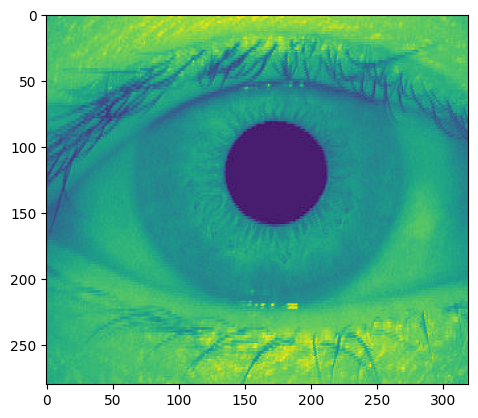

In [ ]:
#need to run the next code segment first otherwise messes up the test.jpg since segment is gonna run twice
#ciriris, cirpupil, imwithnoise = segment(im, 80, False)
#plt.imshow(im)


In [ ]:
imIris = cv2.imread("/Users/sadeghin/research/Iris/example/Iris-Recognition/python/test.jpg", 0)
cimgIris = cv2.cvtColor(imIris,cv2.COLOR_GRAY2BGR)



cv2.circle(cimgIris,(ciriris[0]-20,ciriris[1]-73),ciriris[2],(0,100,255),2)
# draw the center of the circle
cv2.circle(cimgIris,(ciriris[0]-20,ciriris[1]-73),2,(0,100,255),3)

cv2.circle(cimgIris,(cirpupil[0]-13,cirpupil[1]-73),cirpupil[2],(0,255,0),2)
# draw the center of the circle 
cv2.circle(cimgIris,(cirpupil[0]-13,cirpupil[1]-73),2,(0,255,0),3)

cv2.imshow('detected circle - im iris',cimgIris) 
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [ ]:
print(cimg.shape)
print(cimgIris.shape)
print(ciriris)
print(cirpupil)

(280, 320, 3)
(207, 207, 3)
[157, 167, 103]
[157, 168, 50]


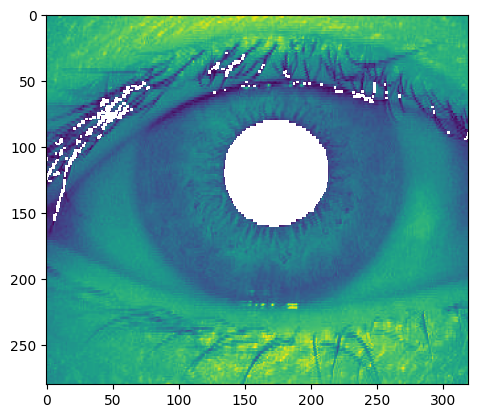

In [ ]:
plt.imshow(imwithnoise)

In [ ]:
#plt.imshow(cimg, cmap="gray")
circles = np.uint16(np.around(circles))
for i in circles[0,0:2]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,0,255),3)
cv2.imshow('detected circles',cimg) 
cv2.waitKey(0)
cv2.destroyAllWindows()  

In [ ]:
cv2.destroyAllWindows()      

In [ ]:
plt.imshow(im, cmap="gray")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/sadeghin/research/Iris/example/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/yh/c929kz3j4tz25sh2jchw222st1j496/T/ipykernel_70687/45822756.py", line 1, in <module>
    plt.imshow(im, cmap="gray")
NameError: name 'plt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/sadeghin/research/Iris/example/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/sadeghin/research/Iris/example/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/sadeghin/research/Iris/example/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1177, in structured_trace

In [ ]:
example = scipy.io.loadmat("/Users/sadeghin/research/Iris/example/Iris-Recognition/python/templates/temp/001_1_2.jpg.mat")


In [ ]:
print((example["mask"]).min())

1.0


(20, 480)


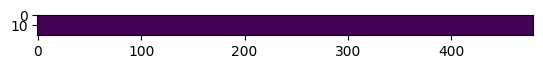

In [ ]:
print(example["template"].shape)
plt.imshow(example["template"])

In [ ]:
# Segmentation parameters
eyelashes_thres = 80

# Normalisation parameters
radial_res = 20
angular_res = 240

# Feature encoding parameters
minWaveLength = 18
mult = 1
sigmaOnf = 0.5

im_filename = "../CASIA1/1/001_1_1.jpg"

print("before reading image" + im_filename)
im = imread(im_filename, 0)
print("read image")
use_multiprocess=False
ciriris, cirpupil, imwithnoise = segment(im, eyelashes_thres, use_multiprocess)
print(ciriris)
print(cirpupil)
print(imwithnoise)
print("after segmenting image")

before reading image../CASIA1/1/001_1_1.jpg
read image
segment
img
[[173 171 170 ... 179 184 170]
 [172 170 170 ... 186 184 171]
 [173 172 171 ... 196 185 172]
 ...
 [156 154 152 ... 172 183 194]
 [156 154 151 ... 170 180 191]
 [155 153 150 ... 169 176 185]]
inner bound
134.0
[137, 180, 99]
[134, 182, 37]
[[173. 171. 170. ... 179. 184. 170.]
 [172. 170. 170. ... 186. 184. 171.]
 [173. 172. 171. ... 196. 185. 172.]
 ...
 [156. 154. 152. ... 172. 183. 194.]
 [156. 154. 151. ... 170. 180. 191.]
 [155. 153. 150. ... 169. 176. 185.]]
after segmenting image


In [ ]:
im = cv2.imread("/Users/sadeghin/research/Iris/example/Iris-Recognition//CASIA1/1/001_1_2.jpg", 0)
print(im.shape)
img = cv2.medianBlur(im,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

cv2.circle(cimg,(171, 141),100,(0,255,0),2)
cv2.circle(cimg,(173, 138),39,(0,255,0),2)
# draw the center of the circle
cv2.circle(cimg,(171,141),2,(0,0,255),3)
cv2.circle(cimg,(173,138),2,(0,0,255),3)

cv2.imshow('detected circles',cimg) 
cv2.waitKey(0)
cv2.destroyAllWindows()  

(280, 320)


: 

: 

In [ ]:
# Segmentation parameters
eyelashes_thres = 80

# Normalisation parameters
radial_res = 20
angular_res = 240

# Feature encoding parameters
minWaveLength = 18
mult = 1
sigmaOnf = 0.5

print("segment")
im_filename="../CASIA1/1/001_1_2.jpg"
eyeim = imread(im_filename, 0)
rowp, colp, rp = searchInnerBound(eyeim)
print("inner bound")
print(rowp)
row, col, r = searchOuterBound(eyeim, rowp, colp, rp)

# Package pupil and iris boundaries
rowp = np.round(rowp).astype(int)
colp = np.round(colp).astype(int)
rp = np.round(rp).astype(int)
row = np.round(row).astype(int)
col = np.round(col).astype(int)
r = np.round(r).astype(int)
cirpupil = [rowp, colp, rp]
ciriris = [row, col, r]

# Find top and bottom eyelid
imsz = eyeim.shape
irl = np.round(row - r).astype(int)
iru = np.round(row + r).astype(int)
icl = np.round(col - r).astype(int)
icu = np.round(col + r).astype(int)
if irl < 0:
    irl = 0
if icl < 0:
    icl = 0
if iru >= imsz[0]:
    iru = imsz[0] - 1
if icu >= imsz[1]:
    icu = imsz[1] - 1
imageiris = eyeim[irl: iru + 1, icl: icu + 1]

segment
img
[[160 161 166 ... 179 182 180]
 [161 161 166 ... 181 185 183]
 [162 162 165 ... 188 186 178]
 ...
 [142 146 147 ... 186 171 176]
 [137 142 146 ... 186 171 177]
 [134 140 145 ... 180 169 179]]
inner bound
138.0


(201, 201)


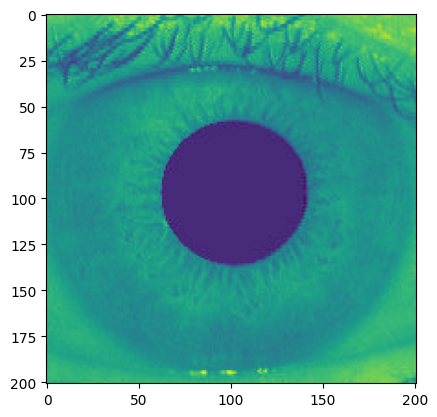

In [ ]:
print(imageiris.shape)
plt.imshow(imageiris)




In [ ]:
ret_top = mp.Manager().dict()
ret_bot = mp.Manager().dict()
p_top = mp.Process(
    target=findTopEyelid,
    args=(imsz, imageiris, irl, icl, rowp, rp, ret_top),
)
p_bot = mp.Process(
    target=findBottomEyelid,
    args=(imsz, imageiris, rowp, rp, irl, icl, ret_bot),
)
p_top.start()
p_bot.start()
p_top.join()
p_bot.join()
mask_top = ret_top[0]
mask_bot = ret_bot[0]

In [ ]:
mask_top = findTopEyelid(imsz, imageiris, irl, icl, rowp, rp)
mask_bot = findBottomEyelid(imsz, imageiris, rowp, rp, irl, icl)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


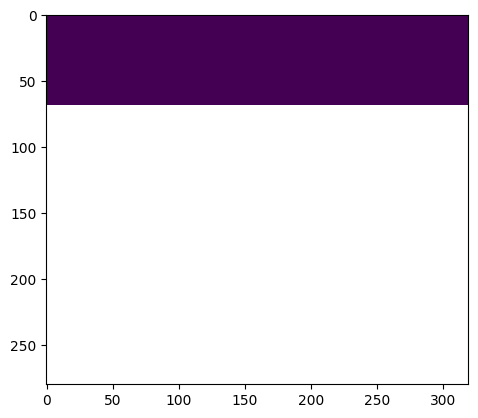

In [ ]:
print(mask_top)
#plt.imshow(mask_top)
plt.imshow(mask_bot)




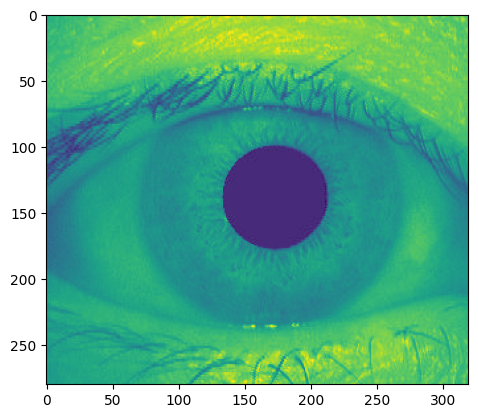

In [ ]:
imwithnoise = eyeim.astype(float)
plt.imshow(imwithnoise)


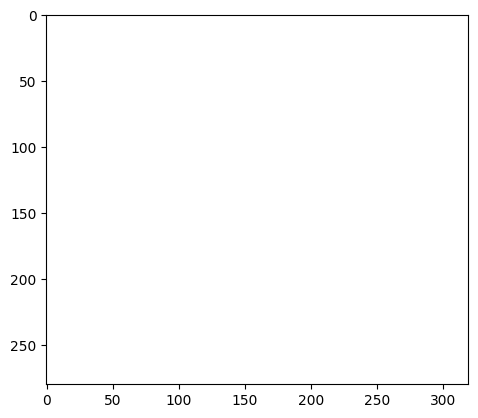

In [ ]:
imwithnoise = imwithnoise + mask_top + mask_bot
plt.imshow(imwithnoise)

[[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 1.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


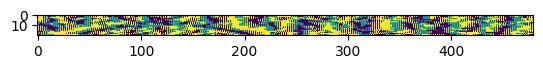

In [ ]:
aaa=scipy.io.loadmat("./templates/temp/001_1_2.jpg.mat")
print(aaa["template"])
plt.imshow(aaa["template"])

In [ ]:
ciriris, cirpupil, imwithnoise = segment(im, eyelashes_thres, use_multiprocess)
print(ciriris)
print(cirpupil)
print(imwithnoise)
print("after segmenting image")

# Perform normalization
polar_array, noise_array = normalize(imwithnoise, ciriris[1], ciriris[0], ciriris[2],
                                        cirpupil[1], cirpupil[0], cirpupil[2],
                                        radial_res, angular_res)

print("after normalizing image")
print(polar_array)
print(noise_array)

segment
img
[[173 171 170 ... 179 184 170]
 [172 170 170 ... 186 184 171]
 [173 172 171 ... 196 185 172]
 ...
 [156 154 152 ... 172 183 194]
 [156 154 151 ... 170 180 191]
 [155 153 150 ... 169 176 185]]
inner bound
134.0
[137, 180, 99]
[134, 182, 37]
[[173. 171. 170. ... 179. 184. 170.]
 [172. 170. 170. ... 186. 184. 171.]
 [173. 172. 171. ... 196. 185. 172.]
 ...
 [156. 154. 152. ... 172. 183. 194.]
 [156. 154. 151. ... 170. 180. 191.]
 [155. 153. 150. ... 169. 176. 185.]]
after segmenting image
xo
(20, 240)
yo
[[134 133 132 ... 136 135 134]
 [134 133 132 ... 136 135 134]
 [134 133 132 ... 136 135 134]
 ...
 [134 132 129 ... 139 136 134]
 [134 132 129 ... 139 136 134]
 [134 132 129 ... 139 136 134]]
avg
0.534890114379085
after normalizing image
[[0.45490196 0.4627451  0.47843137 ... 0.47843137 0.48235294 0.45490196]
 [0.54117647 0.54117647 0.54117647 ... 0.4745098  0.54117647 0.54117647]
 [0.55294118 0.56470588 0.55686275 ... 0.49019608 0.5372549  0.55294118]
 ...
 [0.54509804 0.5294

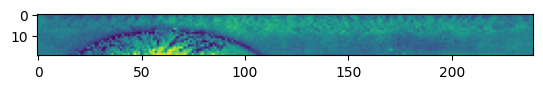

In [ ]:
plt.imshow(polar_array)


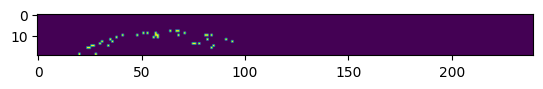

In [ ]:
plt.imshow(noise_array)

In [ ]:
template, mask = encode(polar_array, noise_array, minWaveLength, mult, sigmaOnf)


polararray
[[0.45490196 0.4627451  0.47843137 ... 0.47843137 0.48235294 0.45490196]
 [0.54117647 0.54117647 0.54117647 ... 0.4745098  0.54117647 0.54117647]
 [0.55294118 0.56470588 0.55686275 ... 0.49019608 0.5372549  0.55294118]
 ...
 [0.54509804 0.52941176 0.5254902  ... 0.54901961 0.54509804 0.54509804]
 [0.5372549  0.5254902  0.51764706 ... 0.52941176 0.5254902  0.5372549 ]
 [0.53333333 0.54117647 0.52941176 ... 0.54509804 0.54509804 0.53333333]]
filterbank
(20, 240)
[[-0.00223712+0.00330872j -0.00069603+0.00144347j  0.00117494+0.0019514j
  ...  0.00465382+0.00833311j  0.00136194+0.00812434j
  -0.00150412+0.00630557j]
 [ 0.01727503-0.00406617j  0.01732516+0.00369159j  0.01368683+0.01071627j
  ... -0.00317991-0.01445801j  0.00615618-0.0158293j
   0.01366168-0.0110888j ]
 [ 0.01441365-0.00568228j  0.01654537+0.00190232j  0.01430215+0.00980528j
  ... -0.00640673-0.00791481j  0.00087676-0.01247248j
   0.00888006-0.01101624j]
 ...
 [ 0.00160691+0.00321366j -0.00014083+0.00273686j -0.001

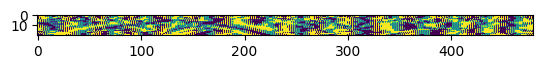

In [ ]:
plt.imshow(template)

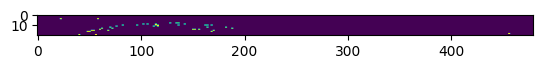

In [ ]:
plt.imshow(mask)

In [ ]:
#------------------------------------------------------------------------------
def calHammingDist(template1, mask1, template2, mask2):
	"""
	Description:
		Calculate the Hamming distance between two iris templates.

	Input:
		template1	- The first template.
		mask1		- The first noise mask.
		template2	- The second template.
		mask2		- The second noise mask.

	Output:
		hd			- The Hamming distance as a ratio.
	"""
	# Initialize
	hd = np.nan

	# Shift template left and right, use the lowest Hamming distance
	for shifts in range(-8,9):
		template1s = shiftbits(template1, shifts)
		mask1s = shiftbits(mask1, shifts)

		mask = np.logical_or(mask1s, mask2)
		nummaskbits = np.sum(mask==1)
		totalbits = template1s.size - nummaskbits

		C = np.logical_xor(template1s, template2)
		C = np.logical_and(C, np.logical_not(mask))
		bitsdiff = np.sum(C==1)

		if totalbits==0:
			hd = np.nan
		else:
			hd1 = bitsdiff / totalbits
			if hd1 < hd or np.isnan(hd):
				hd = hd1

	# Return
	return hd


#------------------------------------------------------------------------------
def shiftbits(template, noshifts):
	"""
	Description:
		Shift the bit-wise iris patterns.

	Input:
		template	- The template to be shifted.
		noshifts	- The number of shift operators, positive for right
					  direction and negative for left direction.

	Output:
		templatenew	- The shifted template.
	"""
	# Initialize
	templatenew = np.zeros(template.shape)
	width = template.shape[1]
	s = 2 * np.abs(noshifts)
	p = width - s

	# Shift
	if noshifts == 0:
		templatenew = template

	elif noshifts < 0:
		x = np.arange(p)
		templatenew[:, x] = template[:, s + x]
		x = np.arange(p, width)
		templatenew[:, x] = template[:, x - p]

	else:
		x = np.arange(s, width)
		templatenew[:, x] = template[:, x - s]
		x = np.arange(s)
		templatenew[:, x] = template[:, p + x]

	# Return
	return templatenew

In [ ]:
# Segmentation parameters
eyelashes_thres = 80
use_multiprocess = False

# Normalisation parameters
radial_res = 20
angular_res = 300 #240

# Feature encoding parameters
minWaveLength = 18
mult = 1
sigmaOnf = 0.5
im = cv2.imread("/Users/sadeghin/research/Iris/example/Iris-Recognition//CASIA1/2/002_2_3.jpg", 0)
ciriris, cirpupil, imwithnoise = segment(im, eyelashes_thres, use_multiprocess)
polar_array, noise_array = normalize(imwithnoise, ciriris[1], ciriris[0], ciriris[2],
                                        cirpupil[1], cirpupil[0], cirpupil[2],
                                        radial_res, angular_res)
template2, mask2 = encode(polar_array, noise_array, minWaveLength, mult, sigmaOnf)

segment - -
img
[[176 180 184 ... 175 173 172]
 [182 184 187 ... 176 178 178]
 [186 186 187 ... 181 181 179]
 ...
 [196 193 196 ... 200 191 196]
 [194 185 192 ... 202 192 195]
 [181 174 189 ... 204 194 197]]
contouring --
contouring --
inner bound -
138.0
searchOuterBound-
Resolution of the circular integration
contouring --
rowp - irl - rp
61
found top eyellid
found lines
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/sadeghin/research/Iris/example/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/yh/c929kz3j4tz25sh2jchw222st1j496/T/ipykernel_23419/2820790588.py", line 14, in <module>
    ciriris, cirpupil, imwithnoise = segment(im, eyelashes_thres, use_multiprocess)
  File "/Users/sadeghin/research/Iris/example/Iris-Recognition/python/fnc/segment.py", line 83, in segment
    mask_top = findTopEyelid(imsz, imageiris, irl, icl, rowp, rp)
  File "/Users/sadeghin/research/Iris/example/Iris-Recognition/python/fnc/segment.py", line 138, in findTopEyelid
    mask[grid] = np.nan
IndexError: index 280 is out of bounds for axis 0 with size 280

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/sadeghin/research/Iris/example/lib/python3.8/site-packages/IPython/core/interactiveshell.p

In [ ]:
hmdistance=calHammingDist(template, mask, template2, mask2)
print(hmdistance)

0.4609031988291867
